In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("Dynamic Price Optimization").getOrCreate()

24/10/21 20:59:57 WARN Utils: Your hostname, ankurPC resolves to a loopback address: 127.0.1.1; using 10.87.1.9 instead (on interface wlp0s20f3)
24/10/21 20:59:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/21 20:59:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Collection

In [3]:
data = spark.read.csv('train.csv', sep='|', header=True, inferSchema=True)
df=pd.read_csv('train.csv',delimiter='|')
data.show()

+------+---+-----+------+------------+---------------+-----+------+-----+-----+-------+
|lineID|day|  pid|adFlag|availability|competitorPrice|click|basket|order|price|revenue|
+------+---+-----+------+------------+---------------+-----+------+-----+-----+-------+
|     1|  1| 6570|     0|           2|           14.6|    1|     0|    0|16.89|    0.0|
|     2|  1|14922|     1|           1|           8.57|    0|     1|    0| 8.75|    0.0|
|     3|  1|16382|     0|           1|          14.77|    0|     1|    0|16.06|    0.0|
|     4|  1| 1145|     1|           1|           6.59|    0|     0|    1| 6.55|   6.55|
|     5|  1| 3394|     0|           1|           4.39|    0|     0|    1| 4.14|   4.14|
|     6|  1| 3661|     0|           1|          13.66|    0|     0|    1|10.03|  10.03|
|     7|  1| 3856|     1|           1|           3.03|    0|     0|    1| 3.58|   3.58|
|     8|  1|16963|     0|           1|           8.78|    1|     0|    0| 8.75|    0.0|
|     9|  1|14560|     0|       

## Data Preprocessing

In [4]:
data.printSchema()

root
 |-- lineID: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- pid: integer (nullable = true)
 |-- adFlag: integer (nullable = true)
 |-- availability: integer (nullable = true)
 |-- competitorPrice: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- basket: integer (nullable = true)
 |-- order: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- revenue: double (nullable = true)



In [5]:
data.describe().show()

24/10/21 21:00:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+------------------+
|summary|           lineID|              day|               pid|             adFlag|      availability|   competitorPrice|              click|             basket|             order|            price|           revenue|
+-------+-----------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+------------------+
|  count|          2756003|          2756003|           2756003|            2756003|           2756003|           2655316|            2756003|            2756003|           2756003|          2756003|           2756003|
|   mean|        1378002.0| 49.9211789682377|10447.897678630974|0.31778884130387375|1.1110347122263655|12.772879581944434|  

In [6]:
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+------+---+---+------+------------+---------------+-----+------+-----+-----+-------+
|lineID|day|pid|adFlag|availability|competitorPrice|click|basket|order|price|revenue|
+------+---+---+------+------------+---------------+-----+------+-----+-----+-------+
|     0|  0|  0|     0|           0|         100687|    0|     0|    0|    0|      0|
+------+---+---+------+------------+---------------+-----+------+-----+-----+-------+



In [7]:
feature_columns = ["day", "pid", "adFlag", "availability", "competitorPrice", "click", "basket", "order"]
data = data.na.drop(subset=feature_columns)

## Exploratory Data Analysis

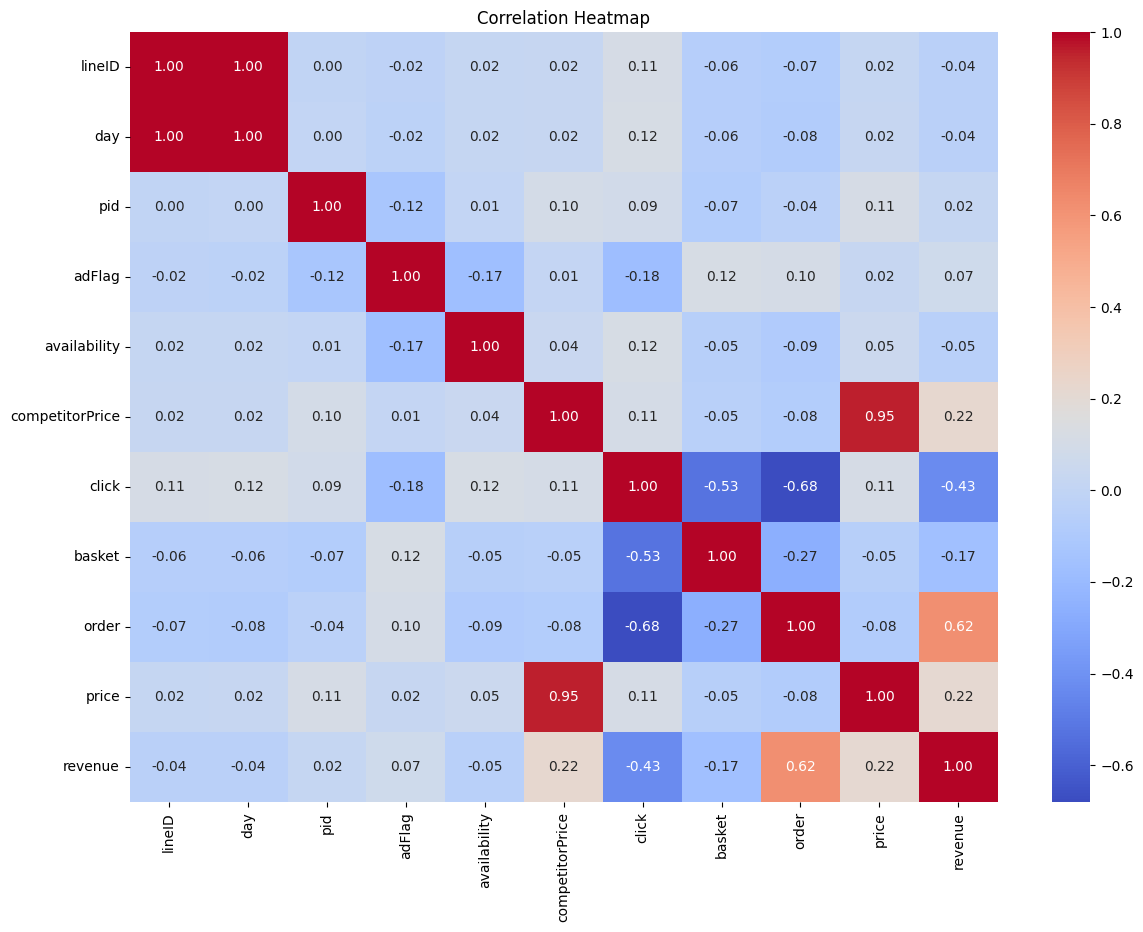

In [8]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

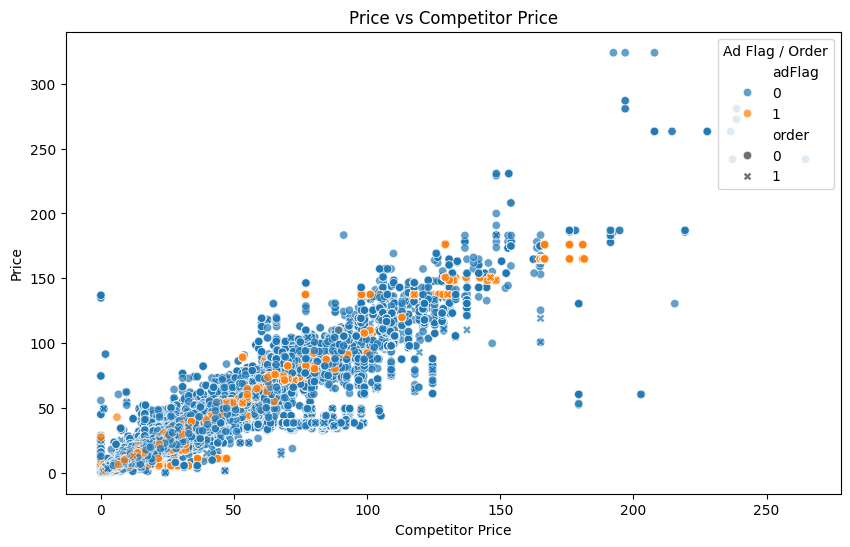

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='competitorPrice', y='price', hue='adFlag', style='order', alpha=0.7)
plt.title("Price vs Competitor Price")
plt.xlabel("Competitor Price")
plt.ylabel("Price")
plt.legend(title='Ad Flag / Order', loc='upper right')
plt.show()

<Figure size 1000x600 with 0 Axes>

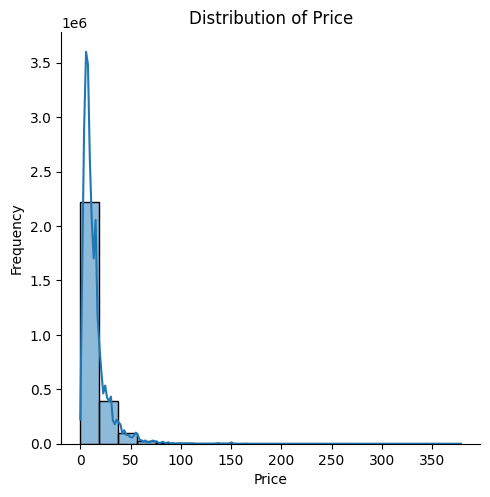

In [27]:
plt.figure(figsize=(10, 6))
sns.displot(df['price'], bins=20, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

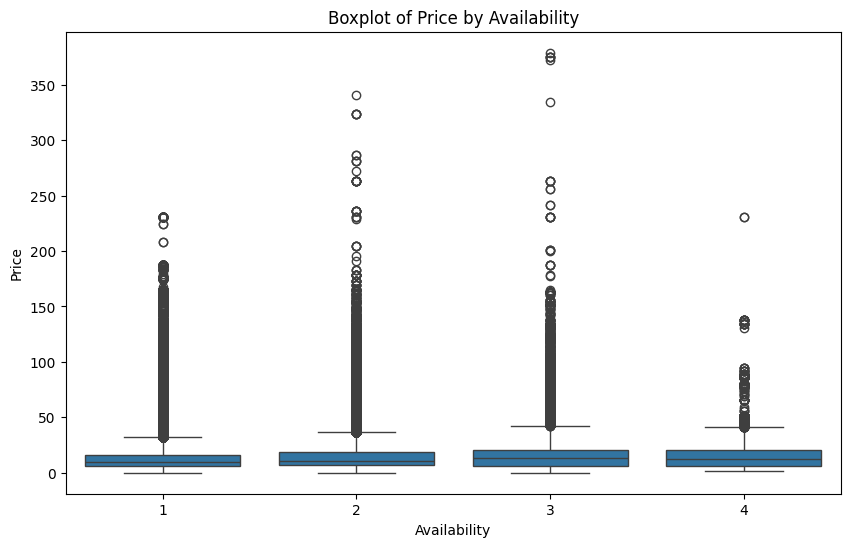

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='availability', y='price')
plt.title("Boxplot of Price by Availability")
plt.xlabel("Availability")
plt.ylabel("Price")
plt.show()

In [12]:
vector_col = "corr_features"
assembler_corr = VectorAssembler(inputCols=feature_columns, outputCol=vector_col)
vector_data = assembler_corr.transform(data)
correlation_matrix = Correlation.corr(vector_data, vector_col).head()[0]
print("Correlation matrix:\n", correlation_matrix)

24/10/21 21:01:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/21 21:01:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Correlation matrix:
 DenseMatrix([[ 1.00000000e+00,  5.02007876e-03, -2.40662822e-02,
               2.10493556e-02,  2.39575362e-02,  1.16749960e-01,
              -6.33350506e-02, -7.74180133e-02],
             [ 5.02007876e-03,  1.00000000e+00, -1.18575036e-01,
               6.78976454e-04,  9.67898837e-02,  8.39943327e-02,
              -7.26767660e-02, -3.23708207e-02],
             [-2.40662822e-02, -1.18575036e-01,  1.00000000e+00,
              -1.73379555e-01,  9.94556752e-03, -1.77419152e-01,
               1.15170294e-01,  1.01366721e-01],
             [ 2.10493556e-02,  6.78976454e-04, -1.73379555e-01,
               1.00000000e+00,  3.64228462e-02,  1.18406946e-01,
              -5.35196113e-02, -8.77354644e-02],
             [ 2.39575362e-02,  9.67898837e-02,  9.94556752e-03,
               3.64228462e-02,  1.00000000e+00,  1.05058281e-01,
              -4.92976471e-02, -7.62858531e-02],
             [ 1.16749960e-01,  8.39943327e-02, -1.77419152e-01,
               1.18

# Predictive Analysis

In [13]:
data = data.withColumn("adFlag", col("adFlag").cast("double"))
assembler = VectorAssembler(inputCols=["day", "pid", "adFlag", "availability", "competitorPrice", "click", "basket"], outputCol="features")
data = assembler.transform(data)

In [14]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

## 1. Linear Regression

In [15]:
lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
print("Linear Regression RMSE:", lr_evaluator.evaluate(lr_predictions))

24/10/21 21:01:51 WARN Instrumentation: [d77a075c] regParam is zero, which might cause numerical instability and overfitting.
24/10/21 21:01:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression RMSE: 3.9059937557022644


## 2. Random Forest

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol="features", labelCol="order")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

rf_evaluator = MulticlassClassificationEvaluator(labelCol="order", predictionCol="prediction", metricName="accuracy")
print("Random Forest Accuracy:", rf_evaluator.evaluate(rf_predictions))

24/10/21 21:02:35 WARN MemoryStore: Not enough space to cache rdd_114_5 in memory! (computed 12.5 MiB so far)
24/10/21 21:02:35 WARN MemoryStore: Not enough space to cache rdd_114_4 in memory! (computed 12.5 MiB so far)
24/10/21 21:02:35 WARN BlockManager: Persisting block rdd_114_5 to disk instead.
24/10/21 21:02:35 WARN BlockManager: Persisting block rdd_114_4 to disk instead.
24/10/21 21:02:35 WARN MemoryStore: Not enough space to cache rdd_114_1 in memory! (computed 12.5 MiB so far)
24/10/21 21:02:35 WARN BlockManager: Persisting block rdd_114_1 to disk instead.
24/10/21 21:02:35 WARN MemoryStore: Not enough space to cache rdd_114_6 in memory! (computed 29.6 MiB so far)
24/10/21 21:02:35 WARN BlockManager: Persisting block rdd_114_6 to disk instead.
24/10/21 21:02:36 WARN MemoryStore: Not enough space to cache rdd_114_2 in memory! (computed 29.6 MiB so far)
24/10/21 21:02:36 WARN BlockManager: Persisting block rdd_114_2 to disk instead.
24/10/21 21:02:40 WARN MemoryStore: Not enoug

Random Forest Accuracy: 1.0


## 3. K-Means Clustering

In [17]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

In [18]:
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(data)
    inertia.append(model.summary.trainingCost)

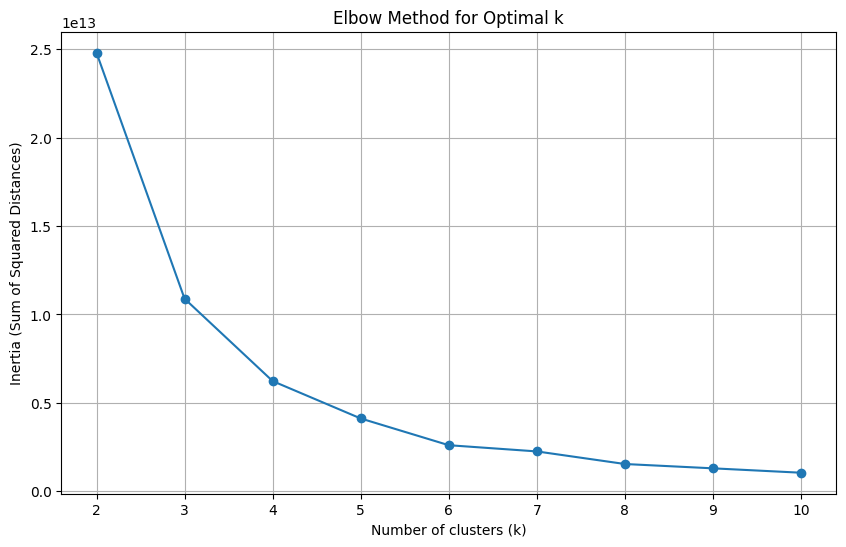

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.xticks(k_values)
plt.grid()
plt.show()

In [20]:
optimal_k = 3  
kmeans = KMeans(k=optimal_k, seed=1)
kmeans_model = kmeans.fit(data)
predictions = kmeans_model.transform(data)

In [21]:
predictions.select("features", "scaled_features", "prediction").show()

+--------------------+--------------------+----------+
|            features|     scaled_features|prediction|
+--------------------+--------------------+----------+
|[1.0,6570.0,0.0,2...|[-1.9334794249093...|         0|
|[1.0,14922.0,1.0,...|[-1.9334794249093...|         1|
|[1.0,16382.0,0.0,...|[-1.9334794249093...|         1|
|[1.0,1145.0,1.0,1...|[-1.9334794249093...|         0|
|[1.0,3394.0,0.0,1...|[-1.9334794249093...|         0|
|[1.0,3661.0,0.0,1...|[-1.9334794249093...|         0|
|[1.0,3856.0,1.0,1...|[-1.9334794249093...|         0|
|[1.0,16963.0,0.0,...|[-1.9334794249093...|         1|
|[1.0,14560.0,0.0,...|[-1.9334794249093...|         1|
|[1.0,4853.0,1.0,1...|[-1.9334794249093...|         0|
|[1.0,14921.0,1.0,...|[-1.9334794249093...|         1|
|[1.0,4055.0,1.0,1...|[-1.9334794249093...|         0|
|[1.0,14010.0,0.0,...|[-1.9334794249093...|         2|
|[1.0,18558.0,0.0,...|[-1.9334794249093...|         1|
|[1.0,5567.0,1.0,1...|[-1.9334794249093...|         0|
|[1.0,1315

In [22]:
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='scaled_features', y='scaled_features', hue='prediction', palette='viridis', alpha=0.6)
# plt.title("K-Means Clustering Results")
# plt.xlabel("Feature 1 (scaled)")
# plt.ylabel("Feature 2 (scaled)")
# plt.legend(title='Cluster')
# plt.show()

In [23]:
def monte_carlo_simulation(data, num_simulations=50):
    results = []
    
    for _ in range(num_simulations):
        sampled_prices = np.random.choice(data['price'], size=len(data), replace=True)
        adjusted_prices = sampled_prices + np.random.normal(0, 1, size=len(sampled_prices))
        
        expected_revenue = np.sum(adjusted_prices * data['order'])
        results.append(expected_revenue)
    
    return results

In [24]:
simulation_results = monte_carlo_simulation(df)

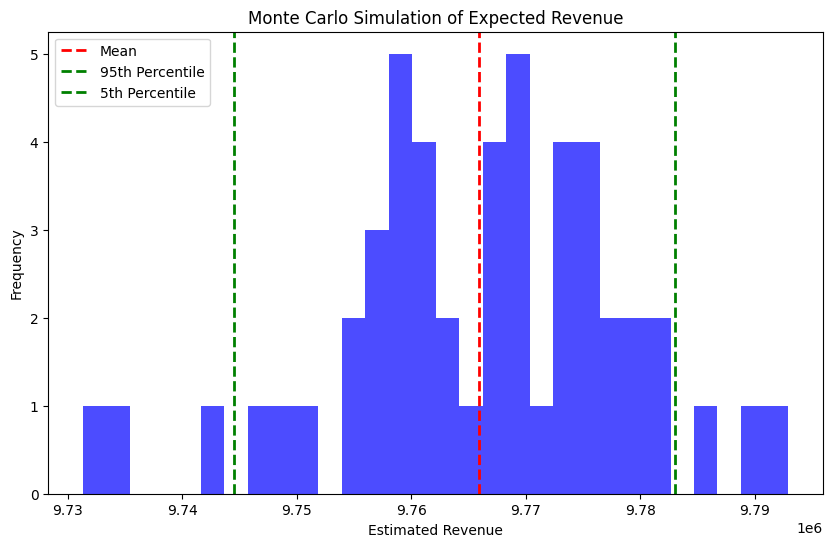

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(simulation_results, bins=30, color='blue', alpha=0.7)
plt.title("Monte Carlo Simulation of Expected Revenue")
plt.xlabel("Estimated Revenue")
plt.ylabel("Frequency")
plt.axvline(np.mean(simulation_results), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(simulation_results, 95), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(simulation_results, 5), color='green', linestyle='dashed', linewidth=2)
plt.legend({"Mean": np.mean(simulation_results), "95th Percentile": np.percentile(simulation_results, 95), "5th Percentile": np.percentile(simulation_results, 5)})
plt.show()

In [26]:
mean_revenue = np.mean(simulation_results)
conf_interval_95 = np.percentile(simulation_results, [5, 95])
print(f"Estimated Mean Revenue: {mean_revenue:.2f}")
print(f"95% Confidence Interval: {conf_interval_95}")

Estimated Mean Revenue: 9765870.54
95% Confidence Interval: [9744553.09281635 9782991.16819228]
